# Image Captioning with LSTM

This is a partial implementation of "Show and Tell: A Neural Image Caption Generator" (http://arxiv.org/abs/1411.4555), borrowing heavily from Andrej Karpathy's NeuralTalk (https://github.com/karpathy/neuraltalk)

This example consists of three parts:
1. COCO Preprocessing - prepare the dataset by precomputing image representations using GoogLeNet
2. RNN Training - train a network to predict image captions
3. Caption Generation - use the trained network to caption new images

### Output
This notebook samples from the trained network to generate captions given an input image.


### Prerequisites

To run this notebook, you'll need the trained GoogLeNet model, as well as the trained RNN model produced by the previous notebook, `lstm_coco_trained.pkl`. This can also be downloaded from https://s3.amazonaws.com/lasagne/recipes/pretrained/lstm_coco_trained.pkl

In [1]:
import sklearn
import numpy as np
import lasagne
import skimage.transform

from lasagne.utils import floatX

import theano
import theano.tensor as T

import matplotlib.pyplot as plt
%matplotlib inline

import json
import pickle

Using gpu device 0: GeForce GTX 770 (CNMeM is disabled)


In [3]:
import googlenet

In [4]:
cnn_layers = googlenet.build_model()
cnn_input_var = cnn_layers['input'].input_var
cnn_feature_layer = cnn_layers['loss3/classifier']
cnn_output_layer = cnn_layers['prob']

get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

In [5]:
model_param_values = pickle.load(open('blvc_googlenet.pkl'))['param values']
lasagne.layers.set_all_param_values(cnn_output_layer, model_param_values)

In [6]:
MEAN_VALUES = np.array([104, 117, 123]).reshape((3,1,1))

def prep_image(im):
    if len(im.shape) == 2:
        im = im[:, :, np.newaxis]
        im = np.repeat(im, 3, axis=2)
    # Resize so smallest dim = 224, preserving aspect ratio
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (224, w*224/h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*224/w, 224), preserve_range=True)

    # Central crop to 224x224
    h, w, _ = im.shape
    im = im[h//2-112:h//2+112, w//2-112:w//2+112]
    
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert to BGR
    im = im[::-1, :, :]

    im = im - MEAN_VALUES
    return rawim, floatX(im[np.newaxis])

Grab a random photo (not from ImageNet or MSCOCO as far as I know)

In [82]:
!wget http://dogspeak101.com/wp-content/uploads/2013/07/Dog-and-Cat-Wallpaper-teddybear64-16834786-1280-800.jpg

--2015-08-28 21:15:12--  http://dogspeak101.com/wp-content/uploads/2013/07/Dog-and-Cat-Wallpaper-teddybear64-16834786-1280-800.jpg
Resolving dogspeak101.com (dogspeak101.com)... 69.163.225.230
Connecting to dogspeak101.com (dogspeak101.com)|69.163.225.230|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 187779 (183K) [image/jpeg]
Saving to: ‘Dog-and-Cat-Wallpaper-teddybear64-16834786-1280-800.jpg’

100%[======================================>] 187,779      215KB/s   in 0.9s   

2015-08-28 21:15:13 (215 KB/s) - ‘Dog-and-Cat-Wallpaper-teddybear64-16834786-1280-800.jpg’ saved [187779/187779]



In [83]:
im = plt.imread('Dog-and-Cat-Wallpaper-teddybear64-16834786-1280-800.jpg')

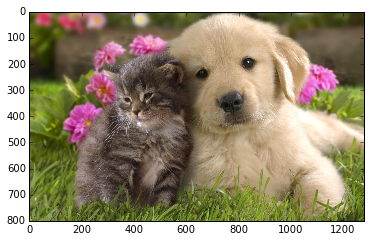

In [84]:
plt.imshow(im)

In [85]:
rawim, cnn_im = prep_image(im)

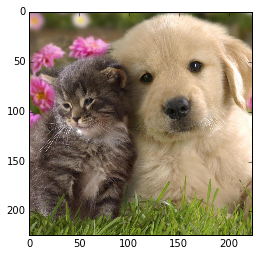

In [86]:
plt.imshow(rawim)

In [89]:
p = get_cnn_features(cnn_im)
CLASSES = pickle.load(open('blvc_googlenet.pkl'))['synset words']
print(CLASSES[p.argmax()])

golden retriever


In [21]:
SEQUENCE_LENGTH = 32
MAX_SENTENCE_LENGTH = SEQUENCE_LENGTH - 3 # 1 for image, 1 for start token, 1 for end token
BATCH_SIZE = 1
CNN_FEATURE_SIZE = 1000
EMBEDDING_SIZE = 512

d = pickle.load(open('lstm_coco_trained.pkl'))
vocab = d['vocab']
word_to_index = d['word_to_index']
index_to_word = d['index_to_word']

In [22]:
l_input_sentence = lasagne.layers.InputLayer((BATCH_SIZE, SEQUENCE_LENGTH - 1))
l_sentence_embedding = lasagne.layers.EmbeddingLayer(l_input_sentence,
                                                     input_size=len(vocab),
                                                     output_size=EMBEDDING_SIZE,
                                                    )

l_input_cnn = lasagne.layers.InputLayer((BATCH_SIZE, CNN_FEATURE_SIZE))
l_cnn_embedding = lasagne.layers.DenseLayer(l_input_cnn, num_units=EMBEDDING_SIZE,
                                            nonlinearity=lasagne.nonlinearities.identity)

l_cnn_embedding = lasagne.layers.ReshapeLayer(l_cnn_embedding, ([0], 1, [1]))

l_rnn_input = lasagne.layers.ConcatLayer([l_cnn_embedding, l_sentence_embedding])
l_dropout_input = lasagne.layers.DropoutLayer(l_rnn_input, p=0.5)
l_lstm = lasagne.layers.LSTMLayer(l_dropout_input,
                                  num_units=EMBEDDING_SIZE,
                                  unroll_scan=True,
                                  grad_clipping=5.)
l_dropout_output = lasagne.layers.DropoutLayer(l_lstm, p=0.5)
l_shp = lasagne.layers.ReshapeLayer(l_dropout_output, (-1, EMBEDDING_SIZE))
l_decoder = lasagne.layers.DenseLayer(l_shp, num_units=len(vocab), nonlinearity=lasagne.nonlinearities.softmax)

l_out = lasagne.layers.ReshapeLayer(l_decoder, (BATCH_SIZE, SEQUENCE_LENGTH, len(vocab)))

In [23]:
lasagne.layers.set_all_param_values(l_out, d['param values'])

In [24]:
x_cnn_sym = T.matrix()
x_sentence_sym = T.imatrix()

output = lasagne.layers.get_output(l_out, {
                l_input_sentence: x_sentence_sym,
                l_input_cnn: x_cnn_sym
                })

f = theano.function([x_cnn_sym, x_sentence_sym], output)

In [93]:
def predict(x_cnn):
    x_sentence = np.zeros((BATCH_SIZE, SEQUENCE_LENGTH - 1), dtype='int32')
    words = []
    i = 0
    while True:
        i += 1
        p0 = f(x_cnn, x_sentence)
        pa = p0.argmax(-1)
        tok = pa[0][i]
        word = index_to_word[tok]
        if word == '#END#' or i >= SEQUENCE_LENGTH - 1:
            return ' '.join(words)
        else:
            x_sentence[0][i] = tok
            if word != '#START#':
                words.append(word)

In [113]:
x_cnn = get_cnn_features(cnn_im)

In [119]:
predict(x_cnn)

u'a dog is laying on a bed with a dog'